Model Evaluation and Comparison:

- Use different evaluation metrics such as accuracy, precision, recall, and F1-score to assess the performance of the models.
- Compare the performance of the different models on both tasks, isCancerous and cell-type classification.
- Explore the use of the extra data provided in the Dataset_extra to improve the performance of the cell-type classification model and compare the results with the model trained on the main dataset.

Visualization:
- Visualize the classification results using confusion matrices, ROC curves, and precision-recall curves.
- Use activation maps or saliency maps to visualize the regions of the images that are important for the classification decision.

# Imports

___

In [77]:
import sys

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
AUTOTUNE = tf.data.experimental.AUTOTUNE

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skimage.transform import resize
from skimage.io import imread

import cv2
import random

import os

sys.path.append('../../src')

In [2]:
dataset_main = pd.read_csv("../data/raw/data_labels_mainData.csv")
dataset_extra = pd.read_csv("../data/raw/data_labels_extraData.csv")

In [3]:
image_folder = "../data/raw/patch_images"
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

# 3. Image Preprocessing

---

There are many modules that can perform preprocessing for images, when dealing with images, we first check to see if all images shares the same resolution, this is crucial since otherwise features will not match and can potentially crash the program. In this case, we use Keras for importing images for Neural Network use, and cv2 for other models that do not use Keras.

## 3.1 For models without using Keras

To check if all images share the same width and height:

In [4]:
resolutions = set()

for i, image_path in enumerate(image_paths):
    im = cv2.imread(image_path)
    resolutions.add(im.shape)
    
print(resolutions)

{(27, 27, 3)}


Since all images have the same resolution, no rescaling, shifting or rotating operation needs to be done.

In [5]:
images = []

for img in range(len(dataset_main)):
    img_array=imread(os.path.join(image_folder, str(dataset_main['ImageName'][img])))
    # Convert multi-dimensional array into 1D array
    img_array = img_array.flatten()
    # Convert to float for normalisation
    img_array = img_array.astype(float)
    for i in range(len(img_array)):
        # Normalise
        img_array[i] = img_array[i]/255
    images.append(img_array.flatten())
    

# print(images)

In [6]:
image_repo = pd.DataFrame(images)
image_repo

,0,1,2,3,4,5,6,7,8,9,...,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186
0,0.949020,0.835294,0.929412,0.937255,0.819608,0.913725,0.921569,0.803922,0.898039,0.913725,...,0.874510,0.788235,0.592157,0.760784,0.709804,0.517647,0.686275,0.764706,0.576471,0.745098
1,0.866667,0.686275,0.827451,0.878431,0.686275,0.827451,0.913725,0.721569,0.858824,0.901961,...,0.937255,0.941176,0.811765,0.905882,0.968627,0.835294,0.933333,0.992157,0.858824,0.956863
2,0.968627,0.952941,0.968627,0.972549,0.949020,0.964706,0.968627,0.937255,0.956863,0.960784,...,0.619608,0.635294,0.419608,0.686275,0.745098,0.529412,0.784314,0.745098,0.529412,0.764706
3,0.952941,0.949020,0.949020,0.952941,0.945098,0.945098,0.952941,0.945098,0.945098,0.952941,...,0.949020,0.949020,0.827451,0.956863,0.972549,0.854902,0.988235,0.847059,0.729412,0.866667
4,0.741176,0.509804,0.741176,0.729412,0.494118,0.721569,0.733333,0.494118,0.717647,0.745098,...,0.941176,0.952941,0.937255,0.945098,0.956863,0.937255,0.949020,0.956863,0.941176,0.956863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9891,0.670588,0.541176,0.705882,0.850980,0.729412,0.894118,0.988235,0.878431,1.000000,0.866667,...,0.772549,0.776471,0.631373,0.811765,0.776471,0.647059,0.811765,0.921569,0.803922,0.905882
9892,0.831373,0.678431,0.894118,0.725490,0.568627,0.811765,0.643137,0.486275,0.713725,0.713725,...,0.901961,0.901961,0.800000,0.894118,0.894118,0.788235,0.886275,0.929412,0.823529,0.925490
9893,0.686275,0.552941,0.756863,0.768627,0.658824,0.819608,0.839216,0.737255,0.870588,0.901961,...,0.643137,0.662745,0.517647,0.733333,0.819608,0.694118,0.854902,0.917647,0.803922,0.945098
9894,0.890196,0.792157,0.909804,0.690196,0.572549,0.756863,0.717647,0.572549,0.768627,0.780392,...,0.913725,0.890196,0.760784,1.000000,0.694118,0.552941,0.792157,0.545098,0.396078,0.631373


image number chosen: [1119, 2901, 7639, 7540, 9412, 9089, 4329, 7462, 9761, 8658, 8935, 4061, 624, 8805, 8409, 2678, 9408, 3411, 13, 2374]


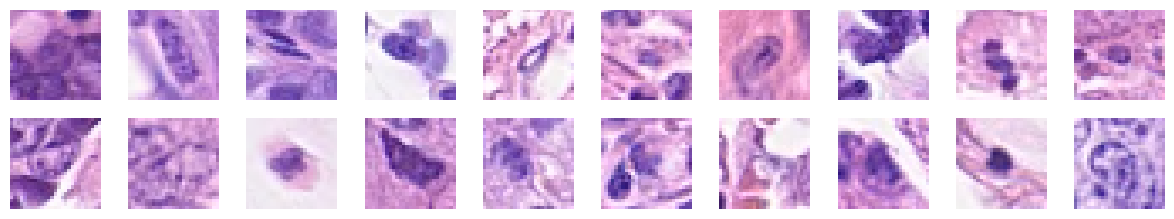

In [7]:
randomlist = []
for i in range(0,20):
    n = random.randint(0,len(images)-1)
    randomlist.append(n)
print('image number chosen:', randomlist)

plt.figure(figsize=(15,4))
for i in range(len(randomlist)):
    plt.subplot(3,10,i+1)
    plt.imshow(images[randomlist[i]].reshape(27, 27, 3),cmap='gray')
    plt.axis('off')
    
plt.show()

## 3.2 Image pre-processing with Keras

In [13]:
def preprocess_data(image_folder, train_data, val_data, test_data, target_size, batch_size):
    # Get the list of image paths for each set
    train_image_paths = [os.path.join(image_folder, filename) for filename in train_data['ImageName'].values]
    val_image_paths = [os.path.join(image_folder, filename) for filename in val_data['ImageName'].values]
    test_image_paths = [os.path.join(image_folder, filename) for filename in test_data['ImageName'].values]
    
    img_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    
    train_generator = img_datagen.flow_from_dataframe(
        train_data,
        directory=image_folder,
        x_col='ImageName',
        y_col='isCancerous',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = img_datagen.flow_from_dataframe(
        val_data,
        directory=image_folder,
        x_col='ImageName',
        y_col='isCancerous',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = img_datagen.flow_from_dataframe(
        test_data,
        directory=image_folder,
        x_col='ImageName',
        y_col='isCancerous',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Define the output dictionary
    output = {
        'train_generator': train_generator,
        'val_generator': val_generator,
        'test_generator': test_generator,
        'num_train_samples': len(train_data),
        'num_val_samples': len(val_data),
        'num_test_samples': len(test_data)
    }
    
    return output

## 3.3 Dataset splitting

In [ ]:
def train_test_split_keras(dataset, train_ratio, val_ratio):
    """ 
    Split data into train, val, test that can be used for Keras.
    
    Returns:
    X_train: the training dataset
    X_val: the validation dataset
    X_test: the testing dataset
    """
    test_size = 1 - train_ratio - val_ratio
    val_size = val_ratio/(1 - test_size)
    X_train, X_test = train_test_split(dataset, test_size = test_size, random_state = 1)
    X_train, X_val = train_test_split(X_train, test_size = val_size, random_state = 1)
    return X_train, X_val, X_test

def Dataset_Split(X, y, train_ratio, val_ratio):
    """
    Split into train, val, cross validate which includes train and val, and test.
    
    Param
    X: dataset
    y: target variable
    train_ratio: percentage of data belong to train
    val_ratio: percentage of data belong to validation
    
    Return
    X_train:
    X_val:
    X_trainCV:
    X_test:
    y_train:
    y_val:
    y_trainCV:
    y_test:
    """
    test_size = 1 - train_ratio - val_ratio
    val_size = val_ratio/(1 - test_size)
    X_trainCV, X_test, y_trainCV, y_test= train_test_split(X, y, test_size = test_size, random_state = 1)
    X_train, X_val, y_train, y_val= train_test_split(X_trainCV, y_trainCV, test_size = val_size, random_state = 1)
    
    return X_train, X_val, X_trainCV, X_test, y_train, y_val, y_trainCV, y_test

# 4. Baseline model with Multi-layer Perceptron

In [9]:
def plot_dataset_distributions(train_data, val_data, test_data, class_columns):
    """
    Plot the distributions of the given columns for the three datasets.

    Parameters:
    train_data (DataFrame): the training dataset
    val_data (DataFrame): the validation dataset
    test_data (DataFrame): the testing dataset
    class_columns (list): a list of column names to plot distributions for

    Returns:
    None
    """

    # Set up the subplots
    fig, axs = plt.subplots(len(class_columns), 3, figsize=(15, 5*len(class_columns)))

    # Loop over each class column
    for i, col in enumerate(class_columns):
        # Plot the distribution for the training set
        axs[i][0].hist(train_data[col], bins=10, color='blue')
        axs[i][0].set_title(f"Training Set - {col} Distribution")

        # Plot the distribution for the validation set
        axs[i][1].hist(val_data[col], bins=10, color='green')
        axs[i][1].set_title(f"Validation Set - {col} Distribution")

        # Plot the distribution for the testing set
        axs[i][2].hist(test_data[col], bins=10, color='orange')
        axs[i][2].set_title(f"Testing Set - {col} Distribution")

    # Set the title of the entire plot
    fig.suptitle("Distribution of Dataset Classes for each set.", fontsize=16)

    # Show the plot
    plt.show()

In [10]:
X_train, X_val, X_test = train_test_split_keras(dataset_main, 0.6, 0.2)

In [11]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_Val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (5937, 6)
Shape of X_Val: (1979, 6)
Shape of X_test: (1980, 6)


In [14]:
X_train['isCancerous'] = X_train['isCancerous'].astype('str')
X_val['isCancerous'] = X_val['isCancerous'].astype('str')
X_test['isCancerous'] = X_test['isCancerous'].astype('str')

preprocessed_data = preprocess_data(
    image_folder=image_folder,
    train_data=X_train,
    val_data=X_val,
    test_data=X_test,
    target_size=(27, 27),
    batch_size=32
)

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [15]:
input_dim = (27, 27, 3)
hidden_layer_dim = 256
output_classes = 2

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dim),
    tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(output_classes)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


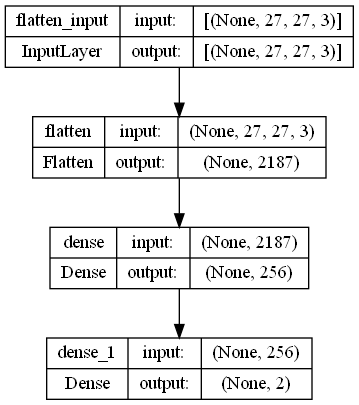

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [21]:
history = model.fit(preprocessed_data['train_generator'], validation_data = preprocessed_data['val_generator'], epochs=50, verbose=0)

## Evaluation of MLP model

In [22]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

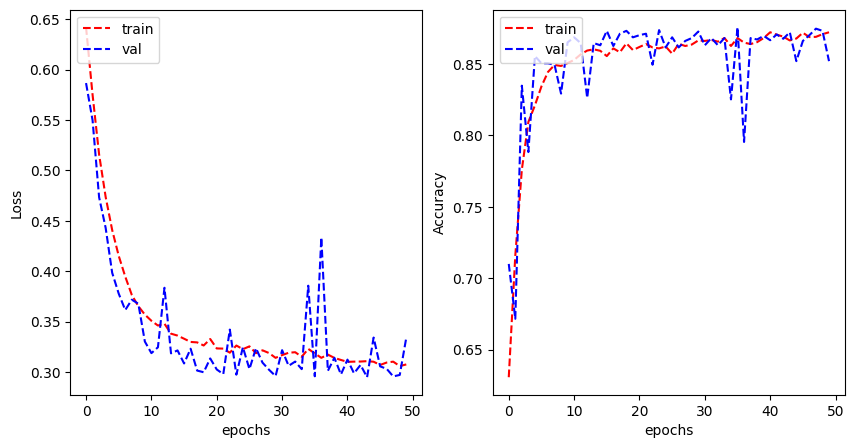

In [23]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [26]:
y_prediction = model.predict(preprocessed_data['val_generator'])
y_prediction = np.argmax (y_prediction, axis = 1)

62/62 [==============================] - 1s 9ms/step


In [27]:
y_true = X_val['isCancerous'].to_numpy(dtype="int64")

In [28]:
result = confusion_matrix(y_true, y_prediction , normalize='pred')
print(result)

[[0.60344828 0.57401813]
 [0.39655172 0.42598187]]


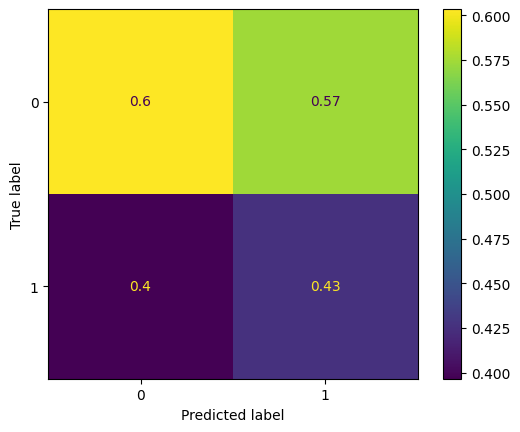

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=[0, 1])
disp.plot()
plt.show()

# Models

## CNN

To construct the model:

In [30]:
def CNN(input_dim, optimizer, metrics):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_dim))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten(input_shape=input_dim))
    model.add(tf.keras.layers.Dense(100, activation='sigmoid'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return model

In [31]:
input_dim = (27, 27, 3)
optimizer = 'SGD'
metrics = ['categorical_accuracy']

cnn_model = CNN(input_dim, optimizer, metrics)

In [32]:
history_cnn = cnn_model.fit(preprocessed_data['train_generator'], validation_data = preprocessed_data['val_generator'], epochs=50, verbose=0)

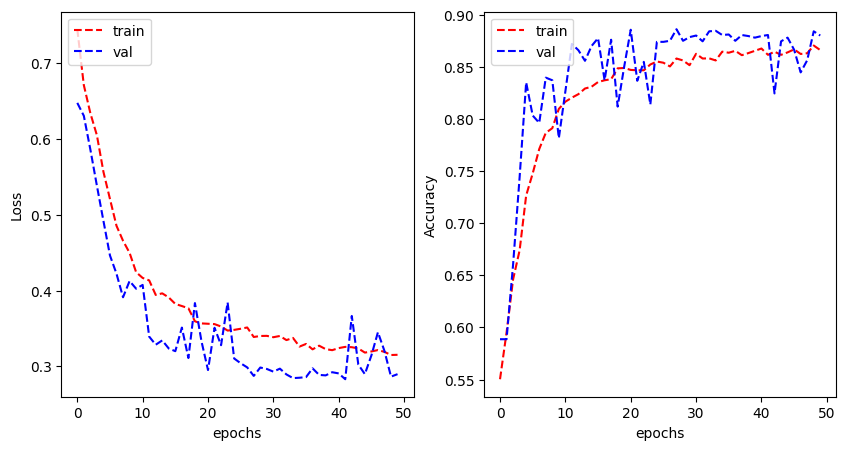

In [33]:
plot_learning_curve(history_cnn.history['loss'], history_cnn.history['val_loss'], 
                    history_cnn.history['categorical_accuracy'], history_cnn.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Evaluation

In [34]:
y_prediction = cnn_model.predict(preprocessed_data['val_generator'])
y_prediction = np.argmax (y_prediction, axis = 1)
y_test = X_val['isCancerous'].to_numpy(dtype="int64")
result = confusion_matrix(y_test, y_prediction , normalize='pred')

62/62 [==============================] - 1s 10ms/step


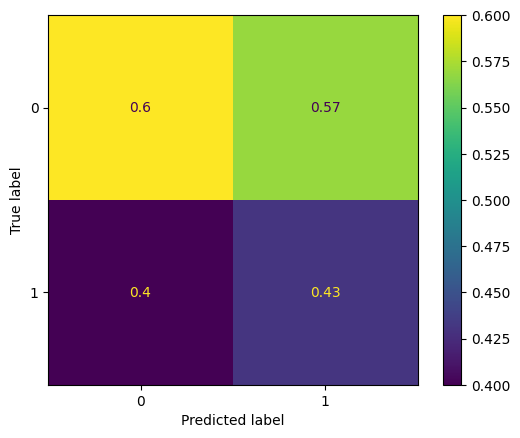

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=[0, 1])
disp.plot()
plt.show()

## VGG

In [37]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(output_classes),
])

In [38]:
model_VGG_1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [40]:
history_VGG_1 = model_VGG_1.fit(preprocessed_data['train_generator'], 
                                           validation_data=preprocessed_data['val_generator'], 
                                           epochs=25, 
                                           verbose=0)

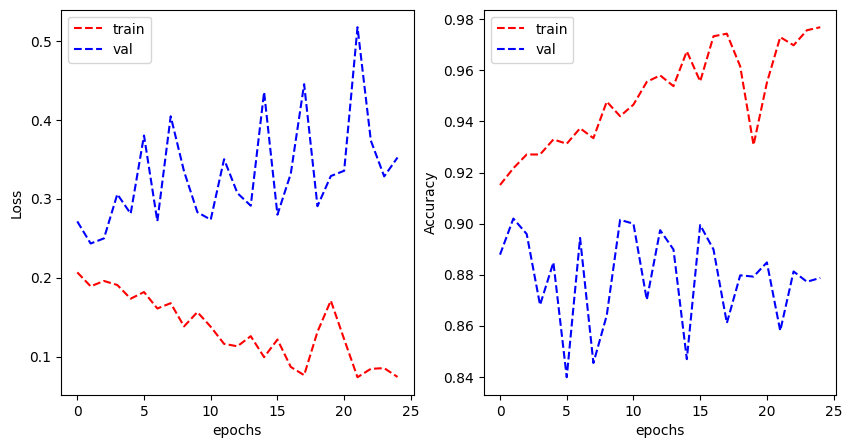

In [42]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

62/62 [==============================] - 1s 12ms/step


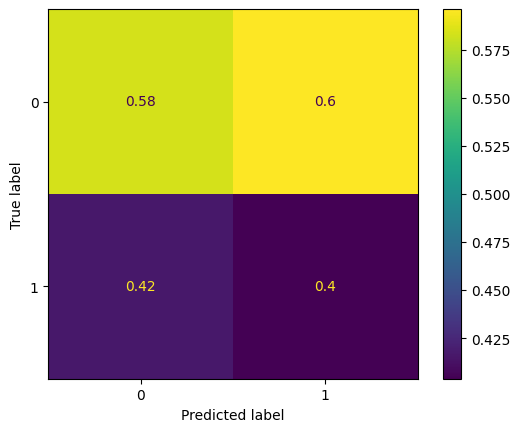

In [43]:
y_prediction = model_VGG_1.predict(preprocessed_data['val_generator'])
y_prediction = np.argmax (y_prediction, axis = 1)
y_test = X_val['isCancerous'].to_numpy(dtype="int64")
result = confusion_matrix(y_test, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=[0, 1])
disp.plot()
plt.show()

In [46]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.58      0.61      0.59      1165
           1       0.40      0.38      0.39       814

    accuracy                           0.51      1979
   macro avg       0.49      0.49      0.49      1979
weighted avg       0.51      0.51      0.51      1979



## SVM

In [ ]:
def SVM(**kwargs):
    model = svm.SVC(**kwargs)
    return model

In [61]:
X_train, X_val, X_trainCV, X_test, y_train, y_val, y_trainCV, y_test = Dataset_Split(image_repo, dataset_main['isCancerous'], 0.6, 0.2)

In [62]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186
7364,0.964706,0.843137,0.984314,0.898039,0.780392,0.905882,0.850980,0.741176,0.862745,0.874510,...,0.776471,0.874510,0.729412,0.878431,0.964706,0.807843,0.968627,0.901961,0.733333,0.898039
5723,0.913725,0.674510,0.882353,0.858824,0.603922,0.823529,0.898039,0.635294,0.874510,0.690196,...,0.909804,0.921569,0.741176,0.890196,0.913725,0.729412,0.878431,0.945098,0.752941,0.905882
7374,0.607843,0.466667,0.768627,0.709804,0.564706,0.850980,0.772549,0.639216,0.898039,0.784314,...,1.000000,0.976471,0.960784,0.984314,0.949020,0.941176,0.956863,0.945098,0.945098,0.952941
5479,0.905882,0.690196,0.933333,0.721569,0.533333,0.784314,0.521569,0.333333,0.596078,0.505882,...,0.827451,0.733333,0.513725,0.760784,0.596078,0.400000,0.650980,0.490196,0.305882,0.600000
5282,0.529412,0.384314,0.674510,0.698039,0.556863,0.772549,0.803922,0.658824,0.819608,0.823529,...,0.576471,0.505882,0.388235,0.662745,0.850980,0.729412,0.925490,0.960784,0.831373,0.972549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166,0.878431,0.741176,0.882353,0.854902,0.713725,0.874510,0.835294,0.686275,0.858824,0.831373,...,0.623529,0.466667,0.301961,0.592157,0.537255,0.360784,0.666667,0.541176,0.368627,0.674510
3466,0.945098,0.890196,0.949020,0.937255,0.878431,0.949020,0.933333,0.854902,0.964706,0.878431,...,0.564706,0.396078,0.250980,0.603922,0.364706,0.227451,0.572549,0.356863,0.223529,0.556863
9883,0.823529,0.647059,0.823529,0.784314,0.603922,0.788235,0.807843,0.627451,0.811765,0.780392,...,0.984314,0.968627,0.807843,0.968627,0.831373,0.674510,0.831373,0.827451,0.678431,0.831373
5173,0.521569,0.309804,0.615686,0.419608,0.231373,0.529412,0.639216,0.439216,0.737255,0.694118,...,0.913725,0.831373,0.694118,0.886275,0.639216,0.501961,0.760784,0.490196,0.349020,0.643137


In [63]:
y_train

7364    0
5723    1
7374    0
5479    1
5282    0
       ..
5166    0
3466    1
9883    1
5173    0
9493    0
Name: isCancerous, Length: 5937, dtype: int64

In [65]:
svm_model = SVM()
svm_result = svm_model.fit(X_train, y_train)

In [66]:
svm_history = svm_result.predict(X_val)

In [67]:
svm_score = accuracy_score(y_val, svm_history)
svm_score

0.9014653865588681

In [68]:
svm_result = confusion_matrix(y_val, svm_history , normalize='pred')

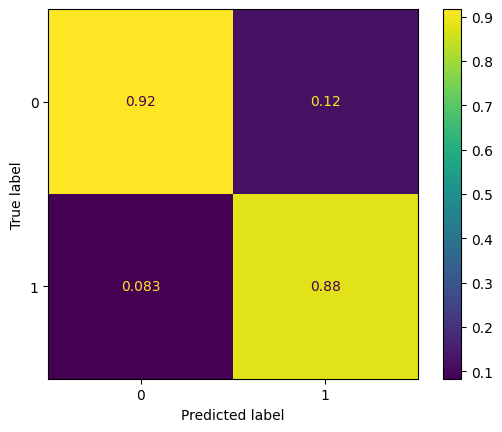

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=svm_result, display_labels=[0, 1])
disp.plot()
plt.show()

## Decision Tree

In [70]:
def Decision_Tree(**kwargs):
    model = DecisionTreeClassifier(**kwargs)
    return model

In [71]:
dt_model = Decision_Tree()

dt_result = dt_model.fit(X_train, y_train)

In [72]:
dt_history = dt_result.predict(X_val)

In [73]:
dt_score = accuracy_score(y_val, dt_history)
dt_score

0.7564426478019202

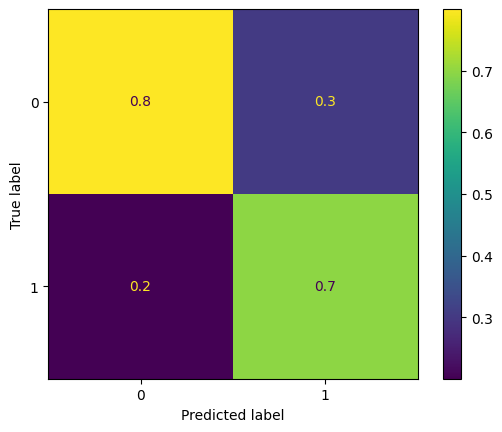

In [74]:
dt_result = confusion_matrix(y_val, dt_history , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=dt_result, display_labels=[0, 1])
disp.plot()
plt.show()

It is theorised that Decision tree will almost always perform worse than Random Forest because Random Forest is designed to resolve issues with overfitting with decision trees by having different instances of trees with random features selected. Therefore, decision tree is a good base model for Random Forest.

## Random Forest

In [75]:
def Random_Forest(**kwargs):
    model = RandomForestClassifier(**kwargs)
    return model

In [78]:
rf_model = Random_Forest()

rf_result = rf_model.fit(X_train, y_train)

In [79]:
rf_history = rf_result.predict(X_val)

In [80]:
rf_score = accuracy_score(y_val, rf_history)
rf_score

0.8756947953511874

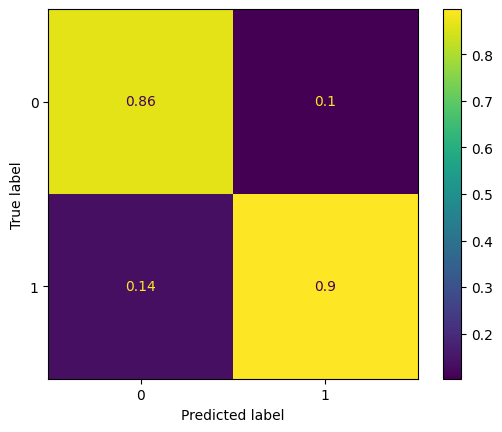

In [81]:
rf_result = confusion_matrix(y_val, rf_history , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=rf_result, display_labels=[0, 1])
disp.plot()
plt.show()

In [83]:
print(classification_report(y_val, rf_history))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1165
           1       0.90      0.79      0.84       814

    accuracy                           0.88      1979
   macro avg       0.88      0.86      0.87      1979
weighted avg       0.88      0.88      0.87      1979



# Hyperparameter Tuning

## Grid Search

In [ ]:
def Grid_Search(**kwargs):
    model = GridSearchCV(**kwargs)
    return model

### Using Random Forest for Grid Search

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 1)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
min_samples_split = [int(x) for x in np.linspace(2, 4, num = 2)]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

all_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = Random_Forest()

rf_grid = Grid_Search(estimator = rf, param_grid = all_grid, cv = 4, verbose=2, n_jobs = -1)


In [ ]:
rf_grid.fit(X_trainCV, y_trainCV)

In [ ]:
def getBest_result(model):
    print(model.best_params_)
    print(rf_grid.best_score_)

In [ ]:
getBest_result(rf_grid)

In [ ]:
rf_grid_best = rf_grid.predict(X_test)

In [ ]:
def getResult(y_test, y_pred):
    model_grid_score = accuracy_score(y_test, y_pred)
    print('Model Accuracy', model_grid_score)
    result = confusion_matrix(y_test, y_pred , normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=[0, 1])
    disp.plot()
    plt.show()
    return model_grid_score

In [ ]:
getResult(y_test, rf_grid_best)

## Random Search

In [ ]:
def Random_Search(**kwargs):
    model = RandomizedSearchCV(**kwargs)
    return model

### Using SVM for Random Search

In [ ]:
C = [int(x) for x in np.linspace(2, 8, num = 4)]
kernel = ['rbf','poly']

param = {"C": C, "kernel": kernel}

svm_model = SVM()
svm_grid = Random_Search(estimator = svm_model, param_distributions = param, refit='accuracy', n_jobs=-1, cv=4, verbose=0, n_iter = 30)

In [ ]:

svm_grid.fit(X_trainCV, y_trainCV)

In [ ]:
getBest_result(svm_grid)

In [ ]:
svm_random_best = svm_grid.predict(X_test)

In [ ]:
getResult(y_test, svm_random_best)

## Plot Hyperparameters

In [ ]:
def Plot_Hyperparam():
    return None